<a href="https://colab.research.google.com/github/PosgradoMNA/TC5035.10.Equipo6/blob/main/Avance3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

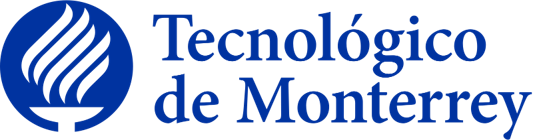

---
# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### **Desarrollo de un Sistema de Visión mediante OpenCV para el Aseguramiento de la Calidad Final de Motores para Aplicaciones Robóticas**
### Profesora Titular: Dra. Grettel Barceló Alonso
### Profesor Titular: Dr. Luis Eduardo Falcón Morales
### Profesor Tutor: María De La Paz Rico Fernández
### Actividad: Avance 2 - Ingeniería de Características
###Alumnos:
* A01793672 - Freddy Armendariz Herrera
* A01793668 - Samuel Elías Flores González
* A01793814 - Emerson Jonathan Rincón Morales
---

---
## **Entendimiento de los Datos**

### **Recolección de Datos Iniciales**

#### ***Importación de Librerías***

In [ ]:
# Descargar Data Set
# ====================================================================
import glob

# Manipulación y Tratamiento de Datos
# ====================================================================
import pandas as pd
import numpy as np

# Gráficos
# ====================================================================
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de Imágenes
# ====================================================================
import cv2
from google.colab.patches import cv2_imshow
import os
from skimage.feature import hog

# Preprocesado y Modelado
# ====================================================================
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Creación de lista con la ruta de cada imagen en el Dataset
okmotor = glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/Motor/Good/*.jpg')
nokmotor = glob.glob('/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/Imagenes/Motor/Bad/*.jpg')

### **Descripción de los Datos**

In [ ]:
#Definir funcion para mostar imagen
def ShowImages(pictures,titles,x,y):

  qty = len(pictures)                                          #qty = Cantidad de imagenes en la lista de imagenes
  fig = plt.figure(figsize=(x, y))                             #fig = crea figura con dimension x, y

  #Itera las imagenes y los titulos para anexarlos a figura
  for i, (img,tit) in enumerate(zip(pictures,titles)):
    a = fig.add_subplot(1,qty,i+1)                             #a = Agrega subplot
    if len(img.shape) == 2:  # Imagen en escala de grises
      imgplot = plt.imshow(img, cmap='gray')
    else:  # Imagen RGB
      imgplot = plt.imshow(img)
    a.set_title(tit)                                           #Establece titulo

  #Muestra figura con imagenes y titulos
  plt.show()

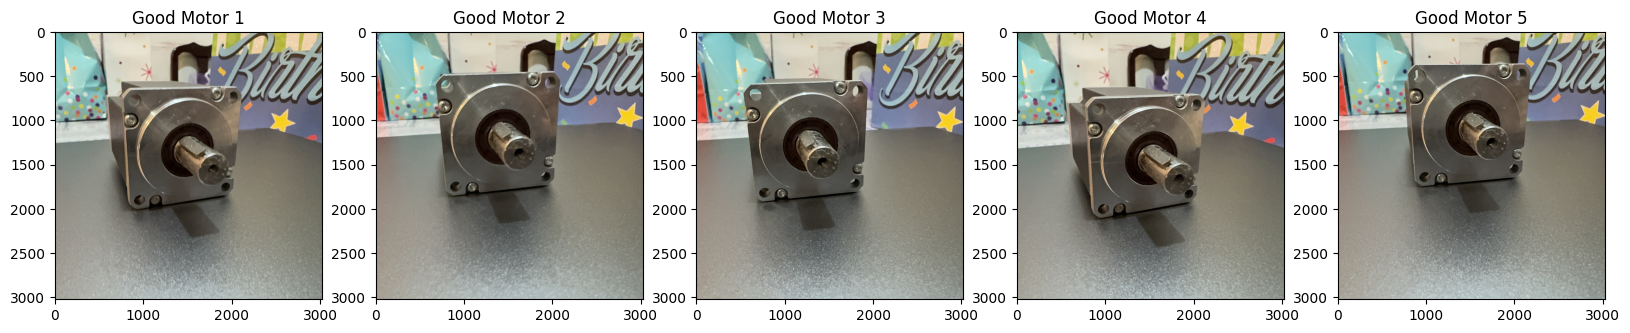

In [ ]:
pics = []
tits = []

for i in range(5):
  i1 = cv2.imread(okmotor[i], cv2.IMREAD_COLOR)
  im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
  pics.append(im1)
  tits.append('Good Motor %d'%(i+1))

ShowImages(pics,tits,20,16)

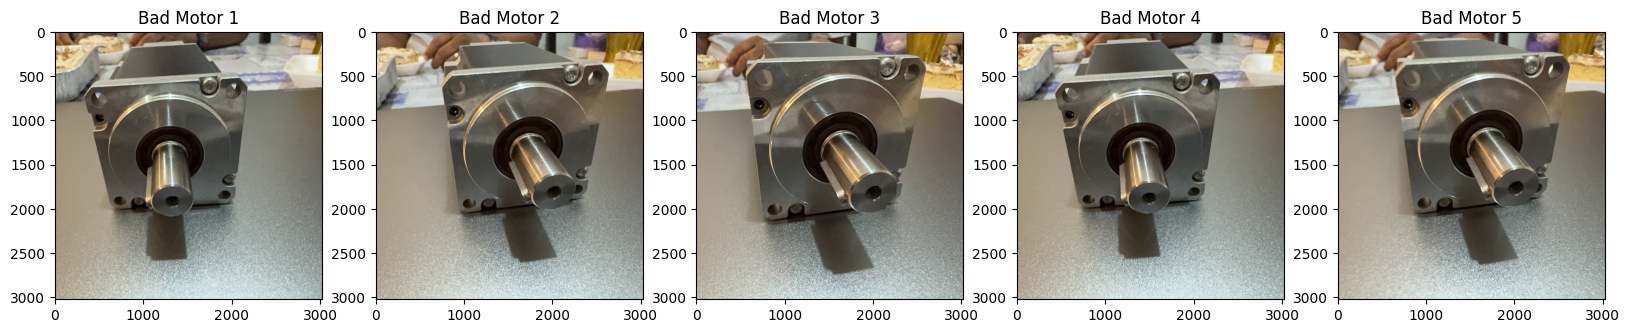

In [ ]:
pics = []
tits = []

for i in range(5):
  i1 = cv2.imread(nokmotor[i], cv2.IMREAD_COLOR)
  im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2RGB)
  pics.append(im1)
  tits.append('Bad Motor %d'%(i+1))

ShowImages(pics,tits,20,16)

### **Exploración de los Datos**

#### ***Lectura de Datasets - Extracción de Features de Imagenes con HOG***

In [ ]:
# Definición de función para extracción de características con Histograma de Gradientes
def HOGFeatures(pictures, width=64, height=64):
  vehicle_hog_accum = []
  vehicle_hog_imgs = []
  new_size = (width, height)
  for i in pictures:
    #img_color = mpimg.imread(i)
    #img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    img_gray = cv2.imread(i,0)
    img_resized = cv2.resize(img_gray, new_size)
    #img_color = cv2.imread(i, cv2.IMREAD_COLOR)
    #img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    vehicle_hog_feature, vehicle_hog_img = hog(img_resized,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),#16*16
                                               cells_per_block = (2,2),#2*2
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    vehicle_hog_accum.append(vehicle_hog_feature)
    vehicle_hog_imgs.append(vehicle_hog_img)

  return vehicle_hog_accum, vehicle_hog_imgs

In [ ]:
okmotors, okmotors_imgs = HOGFeatures(okmotor)

In [ ]:
X_okmotors = np.vstack(okmotors).astype(np.float64)
y_okmotors = np.ones(len(X_okmotors))
print('Tamaño de X_okmotors:',X_okmotors.shape)
print('Tamaño de y_okmotors:',y_okmotors.shape)

Tamaño de X_okmotors: (521, 396)
Tamaño de y_okmotors: (521,)


In [ ]:
nokmotors, nokmotors_imgs = HOGFeatures(nokmotor)

In [ ]:
X_nokmotors = np.vstack(nokmotors).astype(np.float64)
y_nokmotors = np.zeros(len(X_nokmotors))
print('Tamaño de X_nokmotors:',X_nokmotors.shape)
print('Tamaño de y_nokmotors:',y_nokmotors.shape)

Tamaño de X_nokmotors: (502, 396)
Tamaño de y_nokmotors: (502,)


In [ ]:
# Combinación de conjuntos positivo y negativo
X = np.vstack((X_okmotors, X_nokmotors))
y = np.hstack((y_okmotors, y_nokmotors))
print('Tamaño de X: ',X.shape)
print('Tamaño de y: ',y.shape)

Tamaño de X:  (1023, 396)
Tamaño de y:  (1023,)


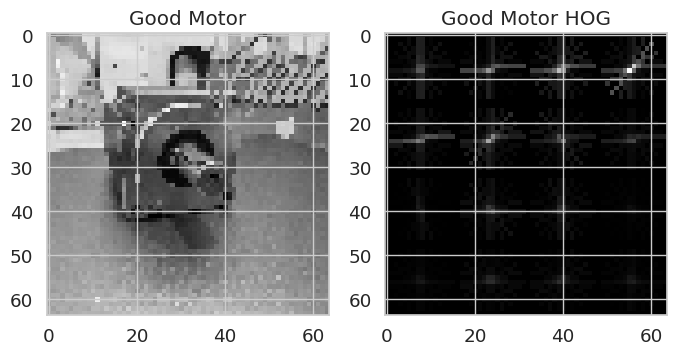

In [ ]:
pics = []
tits = []

i1 = cv2.imread(okmotor[0], cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(i1, cv2.COLOR_BGR2GRAY)
new_size = (64, 64)
im1_resized = cv2.resize(im1, new_size)
pics.append(im1_resized)
tits.append('Good Motor')
pics.append(okmotors_imgs[0])
tits.append('Good Motor HOG')

ShowImages(pics,tits,8,8)

In [ ]:
# Creación de DataFrame
df = pd.DataFrame(X)
df.head()

0         1         2         3         4         5         6    \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

        7         8         9    ...       386       387       388       389  \
0  0.075118  0.116912  0.100536  ...  0.061775  0.034582  0.086003  0.092566   
1  0.092607  0.099691  0.128919  ...  0.083612  0.109859  0.124805  0.126216   
2  0.078076  0.151267  0.100257  ...  0.038327  0.104213  0.075911  0.156987   
3  0.114271  0.123804  0.107881  ...  0.075013  0.077889  0.088727  0.081806   
4  0.146850  0.116628  0.081358  ...  0.150022  0.088644  0.169590  0.125047   

        390       391       392       393       394       395  
0  0.193060  0.106113  0.106467  0.139731  0.093035  0.120283  
1  0.085778  0.158204  0.103753  0.090662  0.129393  0.119916  
2  0.166736  0.193317  0.154253  0.186027  0.191794  0.126947  
3  0.140347  0.100269  0.067425  0.162521  0.109433  0.088335  
4  0.166791  0.093865  0.140944  0.104777  0.121789  0.092693  

[5 rows x 396 columns]

In [ ]:
# Cambio de nombre a las columnas
header = []

for i in range(X.shape[1]):
  x = i+1
  header.append("X%d"%x)

df.columns = header

# Se agrega "y" al dataframe
df['Label'] = y

# Mostrar DataFrame
df.head()

X1        X2        X3        X4        X5        X6        X7  \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

         X8        X9       X10  ...      X388      X389      X390      X391  \
0  0.075118  0.116912  0.100536  ...  0.034582  0.086003  0.092566  0.193060   
1  0.092607  0.099691  0.128919  ...  0.109859  0.124805  0.126216  0.085778   
2  0.078076  0.151267  0.100257  ...  0.104213  0.075911  0.156987  0.166736   
3  0.114271  0.123804  0.107881  ...  0.077889  0.088727  0.081806  0.140347   
4  0.146850  0.116628  0.081358  ...  0.088644  0.169590  0.125047  0.166791   

       X392      X393      X394      X395      X396  Label  
0  0.106113  0.106467  0.139731  0.093035  0.120283    1.0  
1  0.158204  0.103753  0.090662  0.129393  0.119916    1.0  
2  0.193317  0.154253  0.186027  0.191794  0.126947    1.0  
3  0.100269  0.067425  0.162521  0.109433  0.088335    1.0  
4  0.093865  0.140944  0.104777  0.121789  0.092693    1.0  

[5 rows x 397 columns]

### **Verificación de Calidad de los Datos**

In [ ]:
df.shape

(1023, 397)

In [ ]:
df.dtypes

X1       float64
X2       float64
X3       float64
X4       float64
X5       float64
          ...   
X393     float64
X394     float64
X395     float64
X396     float64
Label    float64
Length: 397, dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Columns: 397 entries, X1 to Label
dtypes: float64(397)
memory usage: 3.1 MB


In [ ]:
df.isna().values.any()     #True = Si hay valores nulos

False

---
## **Preparación de los Datos**

### **Preprocesamiento / Limpieza**

In [ ]:
df.describe()

X1           X2           X3           X4           X5  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000   
mean      0.204273     0.116602     0.159195     0.124285     0.127285   
std       0.047379     0.049815     0.060320     0.052402     0.052806   
min       0.045686     0.010785     0.026334     0.006624     0.013380   
25%       0.174465     0.078205     0.110854     0.086747     0.086823   
50%       0.223390     0.114464     0.155405     0.117153     0.123782   
75%       0.237333     0.148419     0.208725     0.158094     0.157565   
max       0.293715     0.259603     0.328637     0.264424     0.291959   

                X6           X7           X8           X9          X10  ...  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000  ...   
mean      0.225696     0.131780     0.112858     0.114074     0.099224  ...   
std       0.050756     0.050743     0.049347     0.050369     0.045442  ...   
min       0.035889     0.016048     0.010946     0.006554     0.003082  ...   
25%       0.199937     0.095428     0.076591     0.076109     0.067452  ...   
50%       0.234014     0.128149     0.108134     0.109460     0.091713  ...   
75%       0.255078     0.163895     0.144506     0.144646     0.126458  ...   
max       0.355962     0.271380     0.262073     0.261335     0.241677  ...   

              X388         X389         X390         X391         X392  \
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000   
mean      0.085498     0.086320     0.098702     0.159759     0.116095   
std       0.031152     0.030872     0.034974     0.039875     0.037222   
min       0.017425     0.024558     0.017441     0.037703     0.026467   
25%       0.063153     0.064214     0.073930     0.130551     0.089122   
50%       0.081012     0.082127     0.095333     0.159613     0.114386   
75%       0.102012     0.102467     0.118248     0.191178     0.138363   
max       0.247273     0.219718     0.220906     0.245226     0.226939   

              X393         X394         X395         X396        Label  
count  1023.000000  1023.000000  1023.000000  1023.000000  1023.000000  
mean      0.110643     0.114181     0.118352     0.112429     0.509286  
std       0.037249     0.038045     0.037391     0.036283     0.500158  
min       0.022573     0.027057     0.029780     0.037449     0.000000  
25%       0.083380     0.087073     0.091509     0.086945     0.000000  
50%       0.108685     0.109680     0.115139     0.108904     1.000000  
75%       0.134418     0.135370     0.141168     0.133594     1.000000  
max       0.232910     0.234355     0.222242     0.240025     1.000000  

[8 rows x 397 columns]

Dado que las características del DataFrame fueron extraídas de imágenes utilizando histograma de gradientes, se pueden hacer las siguientes observaciones:
* No existe sesgamiento
* No hay datos nulos
* Los datos se encuentran normalizados
* Solo existen variables númericas y no categóricas

### **Selección de Características**

In [ ]:
# Separación de Variables de Entrada y Salida
Xdf = df.drop("Label", axis=1)
Ydf = df["Label"]

In [ ]:
Xdf.head()

X1        X2        X3        X4        X5        X6        X7  \
0  0.254142  0.045962  0.146472  0.099399  0.074725  0.152968  0.039518   
1  0.251936  0.093208  0.068914  0.096173  0.053517  0.131456  0.078511   
2  0.240471  0.087092  0.131441  0.062676  0.036507  0.186460  0.056002   
3  0.262344  0.057915  0.058948  0.044376  0.060529  0.167414  0.048964   
4  0.251276  0.117453  0.066621  0.056287  0.059906  0.131531  0.089834   

         X8        X9       X10  ...      X387      X388      X389      X390  \
0  0.075118  0.116912  0.100536  ...  0.061775  0.034582  0.086003  0.092566   
1  0.092607  0.099691  0.128919  ...  0.083612  0.109859  0.124805  0.126216   
2  0.078076  0.151267  0.100257  ...  0.038327  0.104213  0.075911  0.156987   
3  0.114271  0.123804  0.107881  ...  0.075013  0.077889  0.088727  0.081806   
4  0.146850  0.116628  0.081358  ...  0.150022  0.088644  0.169590  0.125047   

       X391      X392      X393      X394      X395      X396  
0  0.193060  0.106113  0.106467  0.139731  0.093035  0.120283  
1  0.085778  0.158204  0.103753  0.090662  0.129393  0.119916  
2  0.166736  0.193317  0.154253  0.186027  0.191794  0.126947  
3  0.140347  0.100269  0.067425  0.162521  0.109433  0.088335  
4  0.166791  0.093865  0.140944  0.104777  0.121789  0.092693  

[5 rows x 396 columns]

Todas las variables son númericas, por lo que no se pueden eliminar variables categóricas.

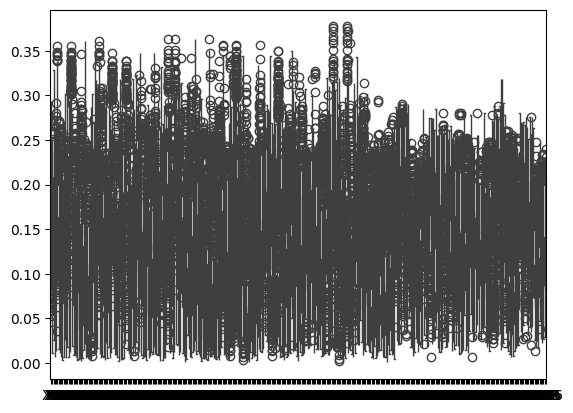

In [ ]:
# Grafico de cajas
sns.boxplot(data = Xdf, orient="v")
plt.show()

<Axes: >

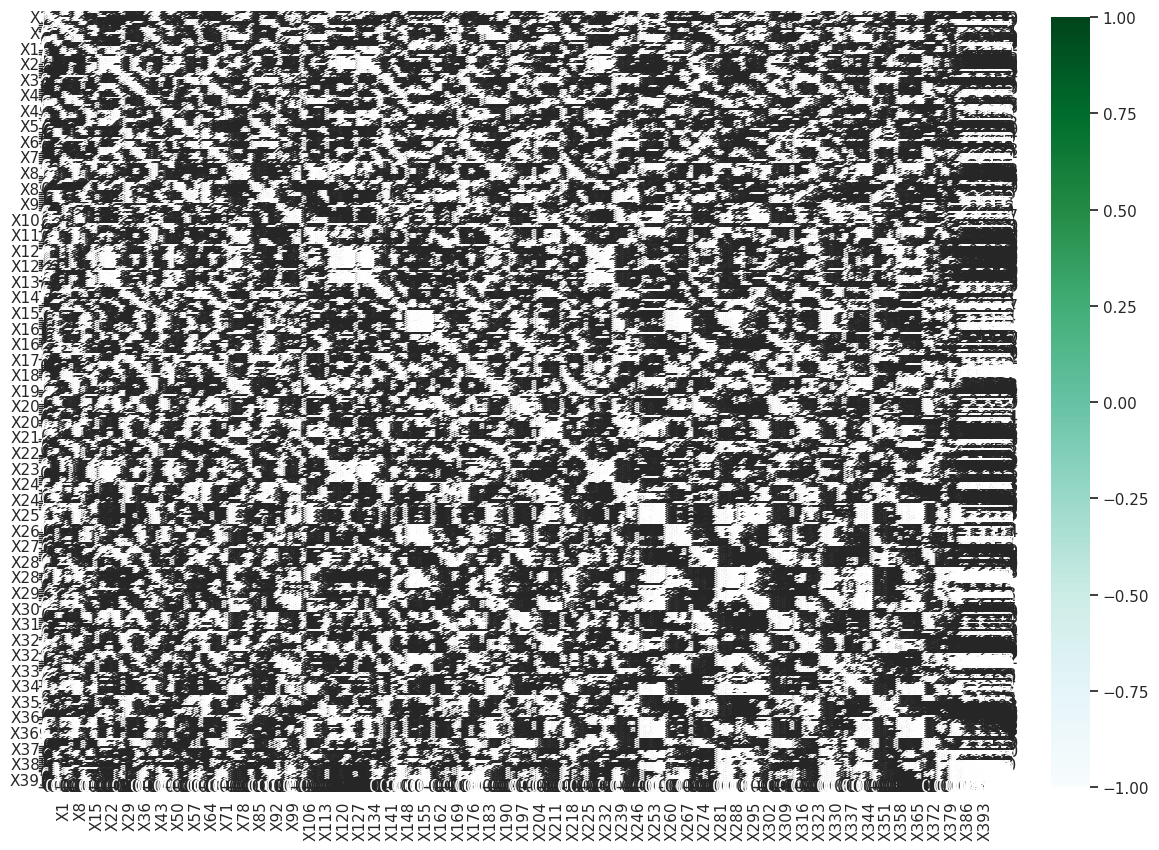

In [ ]:
# Se visualiza la matriz de correlacion
corrs = Xdf.corr()
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corrs, vmin = -1, vmax = 1, cmap = "BuGn", annot= True, fmt=".3f")

In [ ]:
# Exploracion de la varianza
print('Varianza correspondiente a cada columna:')
print(Xdf.var())
print('\nTotal de varianza: ',sum(Xdf.var()))
print('\nProporcion de varianza de cada columna:')
print(np.round(Xdf.var()/sum(Xdf.var()),3)*100)

Varianza correspondiente a cada columna:
X1      0.002245
X2      0.002481
X3      0.003639
X4      0.002746
X5      0.002788
          ...   
X392    0.001385
X393    0.001387
X394    0.001447
X395    0.001398
X396    0.001316
Length: 396, dtype: float64

Total de varianza:  1.0263399625851835

Proporcion de varianza de cada columna:
X1      0.2
X2      0.2
X3      0.4
X4      0.3
X5      0.3
       ... 
X392    0.1
X393    0.1
X394    0.1
X395    0.1
X396    0.1
Length: 396, dtype: float64


Segun su estadistica descriptiva y varianza, se aprecia como los valores entre columnas tienen similares escalas numericas, lo cual produce un bajo indice de varianza. Esto es resultado de tener magnitudes similares en todas las columnas.

### **Escalamiento de Características**

Los rangos y magnitudes entre columnas son similares, por lo que no se requiere una normalización de los datos.

### **Balanceo de Clases**

In [ ]:
print('Total de datos generados:', Ydf.shape[0])
print('Total de datos en la clase positiva', Ydf.sum())
print('Total de datos en la clase negativa', (Ydf.shape[0] - Ydf.sum()))

Total de datos generados: 1023
Total de datos en la clase positiva 521.0
Total de datos en la clase negativa 502.0


Las clases tienen una cantidad similar de datos por lo que se consideran balanceadas.

### **Construcción de Características**

Nuestro conjunto de datos tiene demasiadas dimensiones o características, lo que puede caer en un aumento del espacio de los datos haciendo que los datos se vuelvan dispersos y por ende dificultar la identificación de patrones significativos. También puede provocar overfitting en los modelos al ajustar demasiado a los datos de entrenamiento, reduciendo así la capacidad de generalizar nuevos datos. Además, aumenta el tiempo de entrenamiento de modelos.

Debido a lo anterior se procede a aplicar una reducción de dimensionalidad con PCA.

#### ***Reducción de Dimensiones con PCA***

Paso 1: Estandarización de los Datos
**bold text**Antes de aplicar PCA, es importante estandarizar los datos. Esto implica escalar las características para que tengan una media de 0 y una desviación estándar de 1. La estandarización asegura que todas las características contribuyan de manera equitativa al análisis.
Paso 2: Cálculo de la Matriz de Covarianza
**bold text**La matriz de covarianza describe la variabilidad conjunta de las características en el conjunto de datos. Esta matriz es crucial para PCA ya que se utiliza para identificar las direcciones de máxima varianza.
Paso 3: Cálculo de los Vectores y Valores Propios
**bold text**Los vectores propios (o eigenvectors) y los valores propios (o eigenvalues) de la matriz de covarianza se calculan para identificar las direcciones principales de varianza (componentes principales).
Paso 4: Selección de Componentes Principales
**bold text**Ordena los valores propios de mayor a menor y selecciona los primeros 'k' componentes principales que expliquen la mayor parte de la varianza en los datos. El número de componentes 'k' puede ser determinado por la varianza explicada acumulativa.
Paso 5: Proyección a Subespacio de Menor Dimensión
**bold text**Proyecta los datos originales a los nuevos ejes definidos por los componentes principales seleccionados.
Paso 6 (Opcional): Uso de Librerías de Python (e.g., Scikit-Learn)
**bold text**Para simplificar el proceso, puedes usar librerías como Scikit-Learn que tienen implementaciones optimizadas de PCA.
Paso 7: Interpretación de los Resultados
**bold text**Finalmente, interpreta los resultados obtenidos. Las nuevas características (componentes principales) pueden ser utilizadas para visualizar los datos en un espacio de menor dimensión, entrenar modelos de machine learning, o para realizar más análisis exploratorios.

In [ ]:
# Se aplica PCA
Dimensiones = 20
pcs = PCA(Dimensiones)
pcs_t = pcs.fit_transform(Xdf)
pcs_t

array([[ 0.04525833, -0.18565459,  0.0191113 , ...,  0.10336194,
        -0.04393374,  0.06814485],
       [-0.13170387, -0.12258905, -0.19272557, ...,  0.17145581,
         0.02261681,  0.05555199],
       [-0.4075189 ,  0.10040357, -0.04845143, ...,  0.05528087,
         0.15444048, -0.07736513],
       ...,
       [ 0.24645943, -0.40901072,  0.2027406 , ..., -0.07127675,
         0.19229309,  0.07316026],
       [ 0.23632168, -0.49465145,  0.22295932, ...,  0.02194985,
         0.2065016 , -0.00987183],
       [ 0.27737119, -0.3706862 ,  0.19526006, ...,  0.08923903,
         0.14022672,  0.08676487]])

##### ***Explicación de Varianza de los Datos***

In [ ]:
# Explicación de varianza de los datos
pcsSummary_df = pd.DataFrame({'% Varianza Explicada': np.round(pcs.explained_variance_,6) * 100,
                               "Desviación Estándar": np.round(np.sqrt(pcs.explained_variance_),3),
                               "%Proporción de Varianza": np.round(pcs.explained_variance_ratio_,3)*100,
                               '% Varianza Acumulada': np.round(np.cumsum(pcs.explained_variance_ratio_),3)*100
                              })
pcs_labels = [f'PC{i + 1}' for i in range(Dimensiones)]
pcsSummary_df.index = pcs_labels
pcsSummary_df = pcsSummary_df.round(2).transpose()
pcsSummary_df

PC1    PC2    PC3    PC4    PC5    PC6    PC7  \
% Varianza Explicada     11.02   9.37   8.15   5.74   4.67   4.22   2.72   
Desviación Estándar       0.33   0.31   0.28   0.24   0.22   0.20   0.16   
%Proporción de Varianza  10.70   9.10   7.90   5.60   4.60   4.10   2.70   
% Varianza Acumulada     10.70  19.90  27.80  33.40  37.90  42.10  44.70   

                           PC8    PC9   PC10   PC11   PC12   PC13   PC14  \
% Varianza Explicada      2.36   2.04   1.96   1.72   1.42   1.34   1.20   
Desviación Estándar       0.15   0.14   0.14   0.13   0.12   0.12   0.11   
%Proporción de Varianza   2.30   2.00   1.90   1.70   1.40   1.30   1.20   
% Varianza Acumulada     47.00  49.00  50.90  52.60  54.00  55.30  56.40   

                          PC15   PC16   PC17   PC18   PC19   PC20  
% Varianza Explicada      1.17   1.15   1.03   0.99   0.87   0.86  
Desviación Estándar       0.11   0.11   0.10   0.10   0.09   0.09  
%Proporción de Varianza   1.10   1.10   1.00   1.00   0.80   0.80  
% Varianza Acumulada     57.60  58.70  59.70  60.70  61.50  62.40

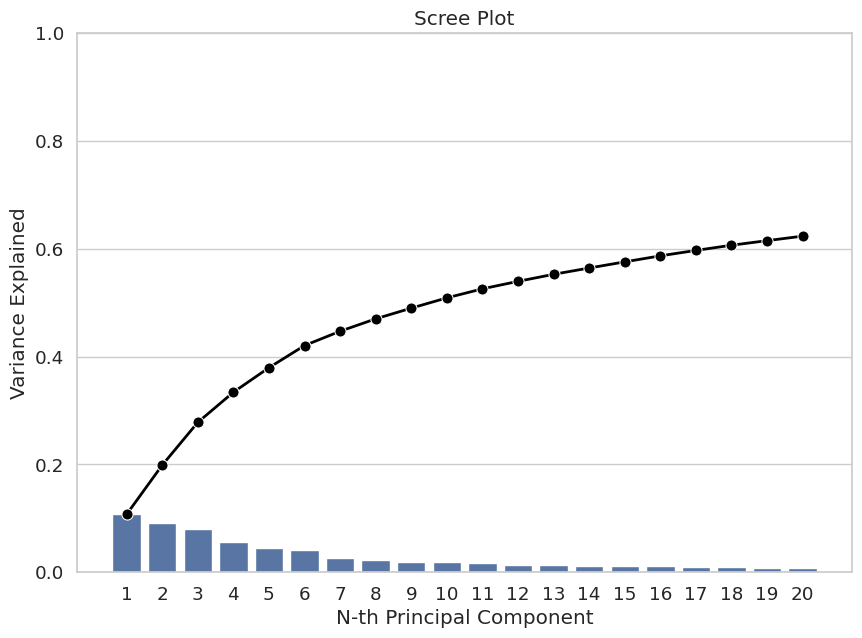

In [ ]:
PC_components = np.arange(pcs.n_components_) + 1
#PC_components

_ = sns.set(style = 'whitegrid',
            font_scale = 1.2
            )

fig, ax = plt.subplots(figsize=(10, 7))

_ = sns.barplot(x = PC_components,
                y = pcs.explained_variance_ratio_,
                color = 'b'
                )

_ = sns.lineplot(x = PC_components-1,
                 y = np.cumsum(pcs.explained_variance_ratio_),
                 color = 'black',
                 linestyle = '-',
                 linewidth = 2,
                 marker = 'o',
                 markersize = 8
                 )

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()

El número mínimo de componentes principales que representan la mayor parte de la variación de nuestros datos son las primeras 20 componentes que nos dan una varianza acumulada de 62.4%.

In [ ]:
# Convertir pcs_t a DataFrame
pcs_df = pd.DataFrame(pcs_t, columns=[f'PC{i+1}' for i in range(Dimensiones)])

# Verifica el resultado
print('Shape of the transformed DataFrame: ',pcs_df.shape)
pcs_df.head()

Shape of the transformed DataFrame:  (1023, 20)


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.045258 -0.185655  0.019111  0.183051  0.032270 -0.259495  0.102131   
1 -0.131704 -0.122589 -0.192726  0.047733 -0.062445 -0.179279  0.124502   
2 -0.407519  0.100404 -0.048451 -0.003685  0.088400 -0.297295  0.129187   
3  0.105350 -0.153523 -0.092770  0.204594  0.059598 -0.235008  0.117891   
4  0.006215 -0.087638 -0.297143 -0.074752 -0.039486 -0.085348  0.311366   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.276816  0.051856 -0.018993  0.206704 -0.073375  0.039744 -0.049833   
1 -0.225973  0.069315  0.029530  0.223222  0.040923  0.090850 -0.098316   
2 -0.022626  0.202789 -0.041420  0.003653 -0.055663  0.048697  0.030254   
3 -0.142623  0.137094 -0.026312  0.283534 -0.156998  0.074953  0.065767   
4 -0.293251  0.163742 -0.068627  0.203100  0.057113  0.002922 -0.100742   

       PC15      PC16      PC17      PC18      PC19      PC20  
0 -0.075588  0.028053  0.044929  0.103362 -0.043934  0.068145  
1 -0.067669  0.132496  0.097726  0.171456  0.022617  0.055552  
2 -0.092786  0.123519  0.077774  0.055281  0.154440 -0.077365  
3 -0.081254  0.011168  0.058609  0.074398  0.008307  0.081628  
4 -0.061557  0.197139  0.065967 -0.017566  0.072969 -0.024180

In [ ]:
pcs_df.describe()

PC1           PC2           PC3           PC4           PC5  \
count  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03   
mean  -6.945677e-18  1.354407e-16  1.849286e-16  1.180765e-16 -3.472838e-18   
std    3.319181e-01  3.060626e-01  2.854799e-01  2.395896e-01  2.161741e-01   
min   -6.303881e-01 -7.225525e-01 -6.991158e-01 -4.877334e-01 -4.981517e-01   
25%   -2.915323e-01 -2.135049e-01 -1.991348e-01 -1.957595e-01 -1.543893e-01   
50%   -5.843100e-02 -4.956910e-03  6.910756e-03 -1.942228e-02 -1.133616e-02   
75%    2.409313e-01  1.562687e-01  2.200371e-01  1.827144e-01  1.473915e-01   
max    8.793228e-01  8.526529e-01  7.580642e-01  6.393603e-01  6.505532e-01   

                PC6           PC7           PC8           PC9          PC10  \
count  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03   
mean   1.146037e-16 -4.514690e-17  1.180765e-16  1.041852e-17 -2.695791e-16   
std    2.053839e-01  1.650426e-01  1.537526e-01  1.426598e-01  1.398972e-01   
min   -4.119991e-01 -5.116577e-01 -3.751471e-01 -4.410412e-01 -5.155225e-01   
25%   -1.792623e-01 -1.023398e-01 -1.216123e-01 -9.973996e-02 -8.211671e-02   
50%   -2.589076e-02 -6.524952e-03 -1.682352e-02 -6.166372e-03 -2.056078e-03   
75%    1.543161e-01  1.086485e-01  1.112437e-01  9.643482e-02  8.710451e-02   
max    5.882600e-01  5.201317e-01  4.490584e-01  4.858494e-01  6.230730e-01   

               PC11          PC12          PC13          PC14          PC15  \
count  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03   
mean  -9.723948e-17  4.861974e-17  2.448351e-16  5.469720e-17 -5.643362e-17   
std    1.312693e-01  1.192803e-01  1.157716e-01  1.094524e-01  1.083243e-01   
min   -4.158111e-01 -3.229919e-01 -3.366612e-01 -3.370156e-01 -3.437423e-01   
25%   -8.057748e-02 -8.561373e-02 -7.569496e-02 -7.904589e-02 -7.272690e-02   
50%   -6.673696e-03  6.918074e-04 -9.647048e-03 -2.323751e-03 -8.453698e-04   
75%    7.363610e-02  7.596838e-02  6.921473e-02  7.128847e-02  6.423316e-02   
max    4.373540e-01  4.272159e-01  4.171355e-01  3.911641e-01  3.515072e-01   

               PC16          PC17          PC18          PC19          PC20  
count  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03  1.023000e+03  
mean  -2.187888e-16  1.024487e-16 -2.938889e-16 -1.910061e-17  8.855738e-17  
std    1.070483e-01  1.016234e-01  9.942476e-02  9.338573e-02  9.261611e-02  
min   -2.748032e-01 -3.299724e-01 -3.166718e-01 -2.816966e-01 -3.085666e-01  
25%   -7.756123e-02 -6.854542e-02 -6.832063e-02 -6.301360e-02 -6.160664e-02  
50%   -3.630389e-03  1.333041e-03 -1.335256e-03  2.295086e-03 -4.645918e-04  
75%    7.260555e-02  6.491584e-02  6.772762e-02  5.898366e-02  5.980370e-02  
max    3.276009e-01  3.838558e-01  3.332743e-01  3.392160e-01  3.885795e-01

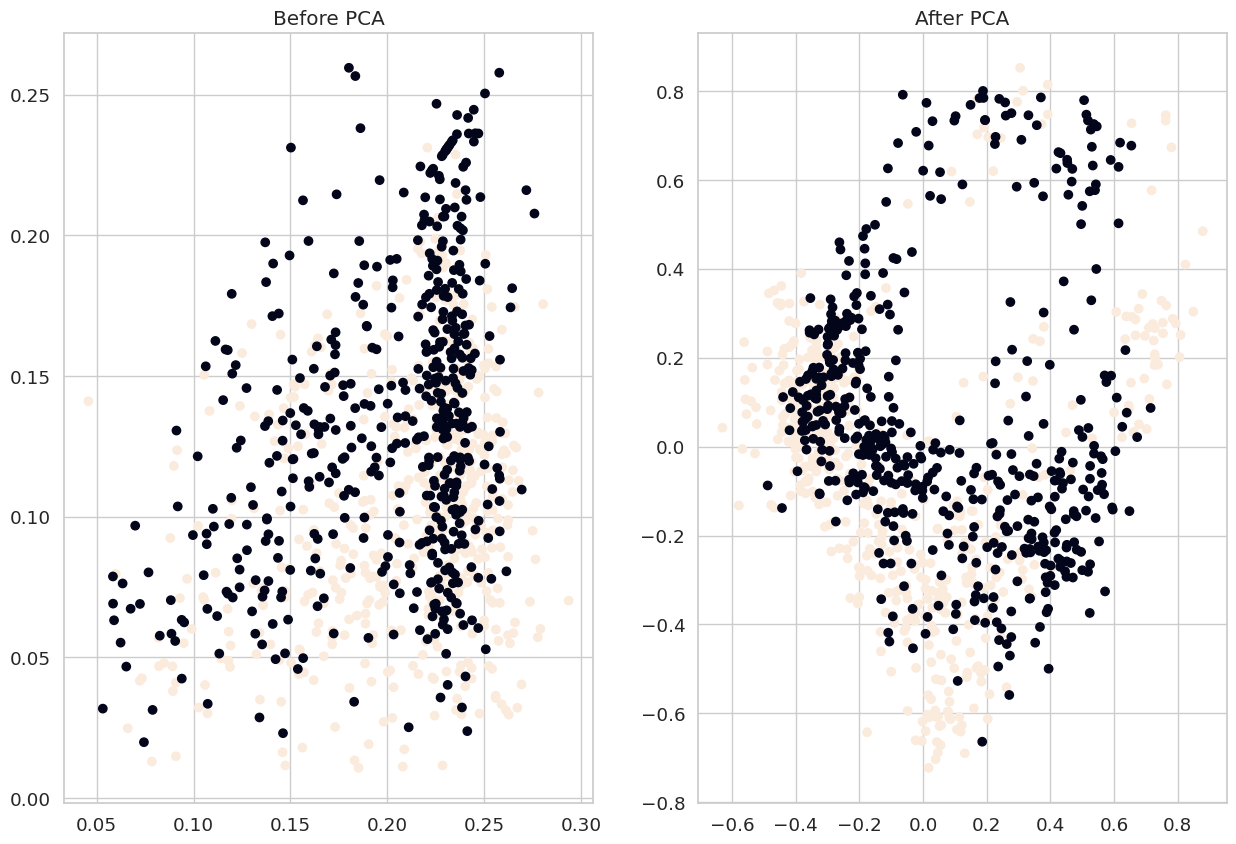

In [ ]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(Xdf["X1"], Xdf["X2"], c=Ydf)
axes[0].set_title('Before PCA')
axes[1].scatter(pcs_df['PC1'], pcs_df['PC2'], c=Ydf)
axes[1].set_title('After PCA')
plt.show()

Se puede observar como despues de aplicar el PCA, utilizando las dos primeras componentes, aminora su varianza distribuyendose de mejor manera, si se visualizan demasiado juntas es debido a la cantidad de registros en el conjunto de datos.

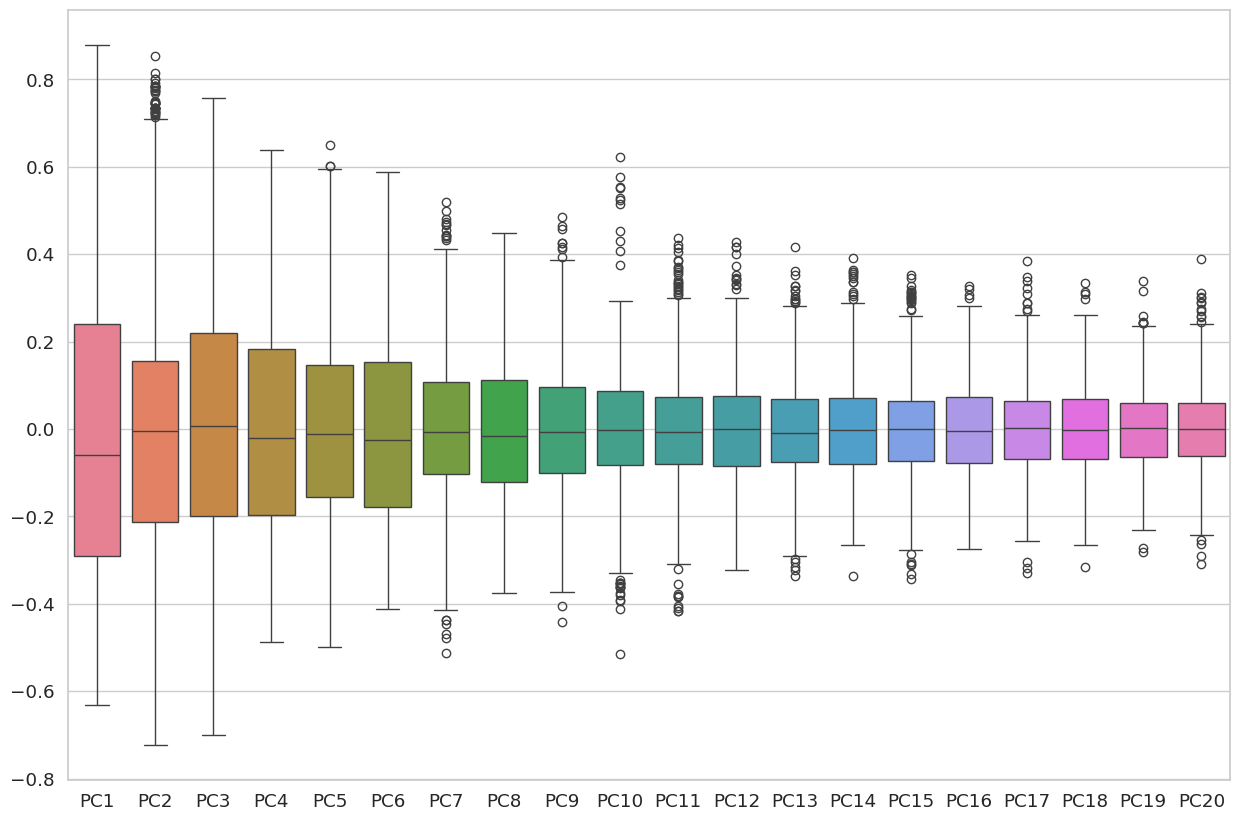

In [ ]:
# Grafico de cajas
sns.boxplot(data = pcs_df, orient="v")
plt.show()

Al haber reducido las componentes, se puede presentar el gráfico de cajas y examinar los outliers del mismo.

##### ***Importancia de las Variables de cada Componente***

In [ ]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(),
                                columns=pcs_df.columns,
                                index=Xdf.columns
                                )
pcsComponents_df.round(3)

PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10  \
X1   -0.009 -0.054 -0.075  0.010  0.024 -0.019 -0.004  0.023  0.018  0.046   
X2    0.026 -0.012 -0.054  0.032 -0.005 -0.026 -0.041 -0.029 -0.024  0.018   
X3    0.029 -0.012  0.037 -0.040 -0.055 -0.020 -0.063  0.022  0.025 -0.016   
X4    0.033 -0.010 -0.004 -0.017 -0.003  0.008 -0.042 -0.052 -0.043 -0.015   
X5    0.030 -0.010  0.036 -0.057  0.009  0.085  0.004 -0.008 -0.052 -0.012   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
X392 -0.042 -0.006 -0.006 -0.065  0.007  0.012  0.039 -0.033 -0.027  0.006   
X393 -0.046 -0.002 -0.001 -0.054 -0.001  0.013  0.031 -0.030 -0.025  0.010   
X394 -0.036  0.004 -0.003 -0.055  0.015  0.014  0.036  0.003 -0.025  0.030   
X395 -0.040  0.010 -0.004 -0.065  0.024  0.019  0.042 -0.015 -0.027  0.038   
X396 -0.027  0.009  0.005 -0.056  0.023  0.014  0.032 -0.020 -0.001  0.043   

       PC11   PC12   PC13   PC14   PC15   PC16   PC17   PC18   PC19   PC20  
X1    0.003  0.008  0.066  0.027  0.067  0.043 -0.007  0.025  0.024  0.035  
X2   -0.139  0.110 -0.021 -0.008  0.053  0.032  0.032  0.059 -0.001 -0.054  
X3   -0.159  0.164  0.074  0.015  0.046 -0.019  0.029  0.085 -0.044 -0.158  
X4   -0.165  0.083 -0.046 -0.010  0.082 -0.015  0.055  0.078  0.048 -0.107  
X5   -0.061  0.010 -0.133 -0.051  0.087 -0.026  0.054  0.043  0.031 -0.070  
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
X392 -0.005  0.005  0.005  0.008 -0.033 -0.002 -0.020  0.025  0.005 -0.007  
X393 -0.002  0.010  0.032  0.002 -0.034  0.009 -0.019  0.025 -0.008 -0.022  
X394  0.016  0.018  0.006  0.019 -0.051 -0.006 -0.007 -0.007  0.003 -0.022  
X395  0.008  0.003  0.019  0.022 -0.025 -0.011 -0.010  0.002  0.021  0.017  
X396 -0.047  0.012  0.013  0.006 -0.034 -0.010  0.014 -0.001 -0.010 -0.023  

[396 rows x 20 columns]

In [ ]:
pcsComponents_df.PC1.abs().idxmax()

'X111'

In [ ]:
pcsComponents_df.PC2.abs().idxmax()

'X127'

In [ ]:
pcsComponents_df.PC3.abs().idxmax()

'X22'

---
## **Modelado**

### **Definición de Conjuntos de Entrenamiento, Validación y Prueba**

Consideraremos un $20\%$ de datos en el conjunto de prueba y dejaremos el resto, $80\%$, para utilizar en validación-cruzada.

In [ ]:
Xtv, Xtest, ytv, ytest = train_test_split(pcs_df, Ydf, test_size=0.2, stratify=Ydf, random_state=1)

print(Xtv.shape, ': dimensión de datos de entrada para entrenamiento y validación')
print(Xtest.shape, ': dimensión de datos de entrada para prueba')

print(ytv.shape, ': dimensión de variable de salida para entrenamiento y validación')
print(ytest.shape, ': dimensión de variable de salida para prueba')

(818, 20) : dimensión de datos de entrada para entrenamiento y validación
(205, 20) : dimensión de datos de entrada para prueba
(818,) : dimensión de variable de salida para entrenamiento y validación
(205,) : dimensión de variable de salida para prueba


### **Definición de Métricas de Desempeño**

In [ ]:
# Definiendo metodo para encontrar las metricas

def mis_metricas(yreal,ypred):
  vn,fp,fn,vp = confusion_matrix(yreal,ypred).ravel()
  accuracy = (vp+vn)/(vp+vn+fp+fn)
  f1score = (2*vp)/(2*vp+fp+fn)
  precision = vp/(vp+fp)
  recall = vp/(vp+fn)
  return accuracy, f1score, precision, recall

In [ ]:
# Definiendo metodo para encontrar matriz de confusion

def mi_cm(yreal, ypred):

  cm = confusion_matrix(yreal, ypred)
  txt = ['Verdaderos Negativos','Falsos Positivos','Falsos Negativos','Verdaderos Positivos']
  short = ["( VN )","( FP )","( FN )","( VP )"]
  frecuencia = ["{0:0.0f}".format(value) for value in cm.flatten()]
  porcentaje = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
  labels = [f"{v1}\n{v2}\n{v3}\n{v4}" for v1, v2, v3, v4 in zip(txt,short,frecuencia,porcentaje)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Spectral', cbar=False)
  ax.set(ylabel="Etiquetas Reales", xlabel="Etiquetas de Predicción")
  plt.show()

### **Modelo de Referencia (Baseline)**

In [ ]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Logística:
  modelos.append(LogisticRegression(solver='liblinear'))
  nombres.append('LR')

  # DM - Dummy
  modelos.append(DummyClassifier(strategy="stratified"))
  nombres.append('DM')

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')

  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:
  modelos.append(MLPClassifier(hidden_layer_sizes=(30,), max_iter=3000))
  nombres.append('MLP')

  # SVM - Máquina de Vector Soporte:
  modelos.append(SVC(gamma='scale'))
  nombres.append('SVM')

  # kNN - k-Vecinos más cercanos:
  modelos.append(KNeighborsClassifier())
  nombres.append('kNN')

  return modelos, nombres

Modelo:  LR


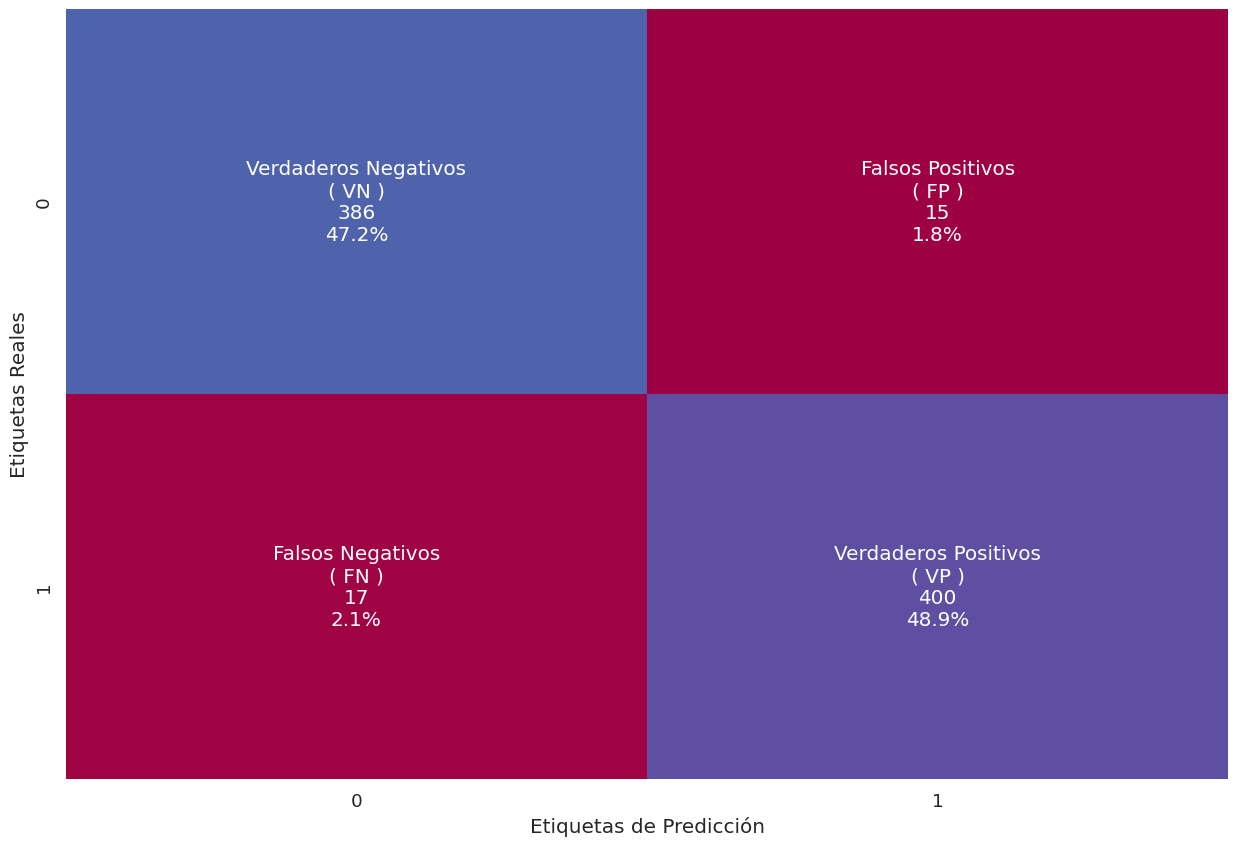

Modelo:  DM


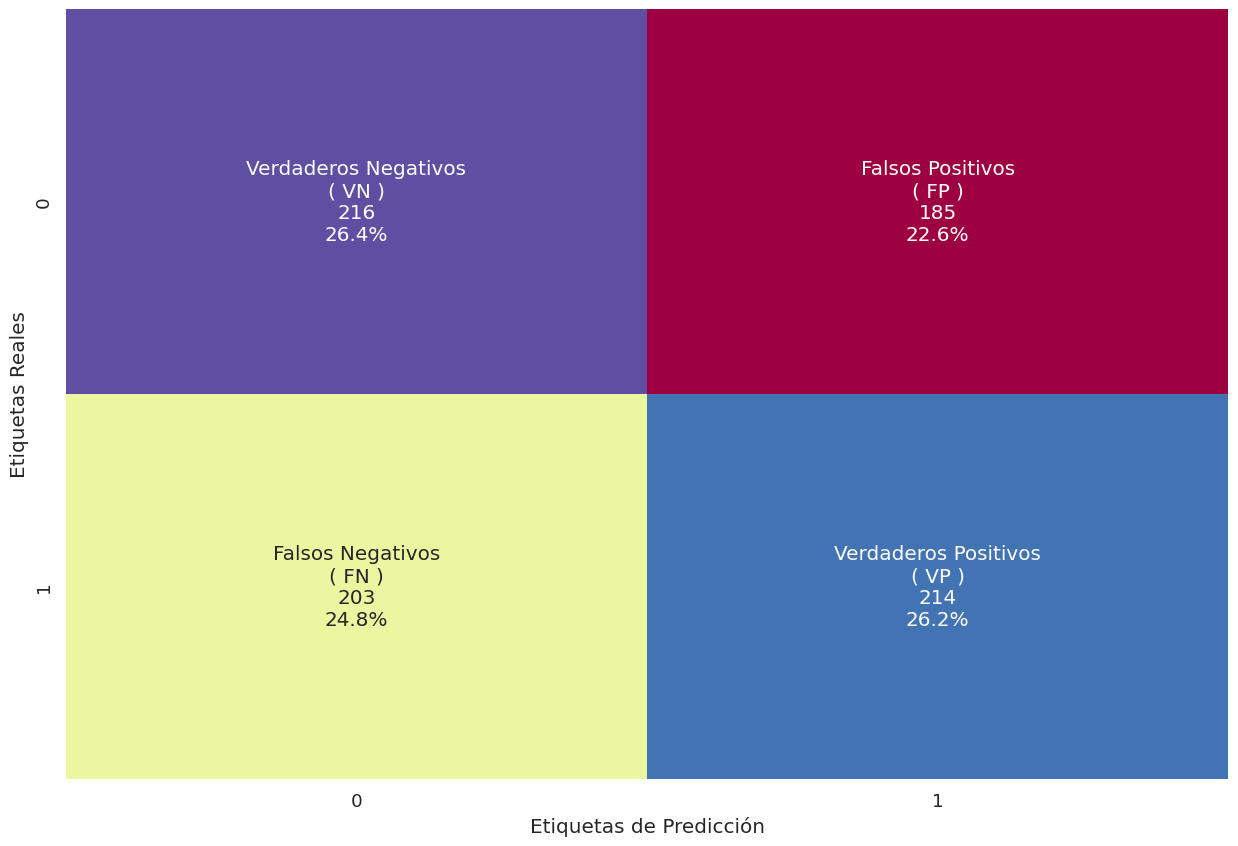

Modelo:  DT


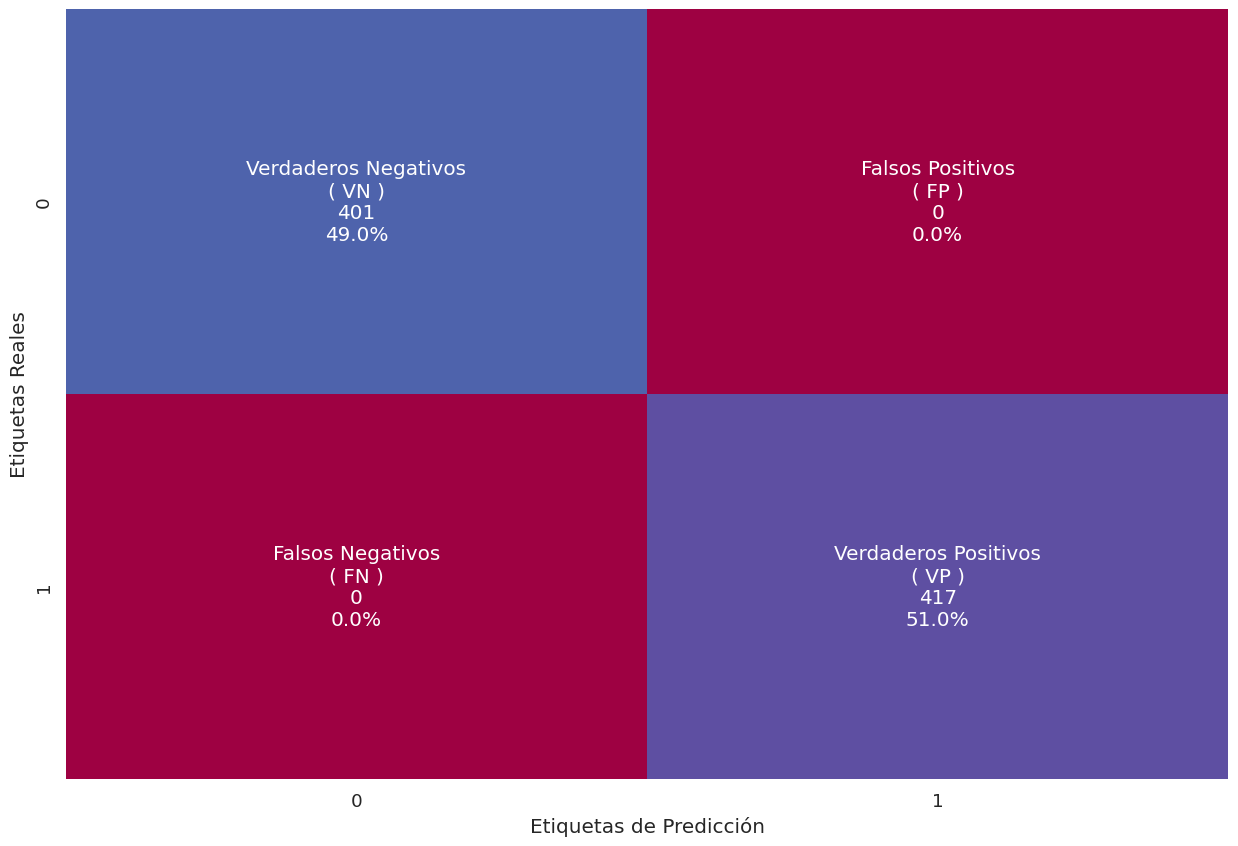

Modelo:  MLP


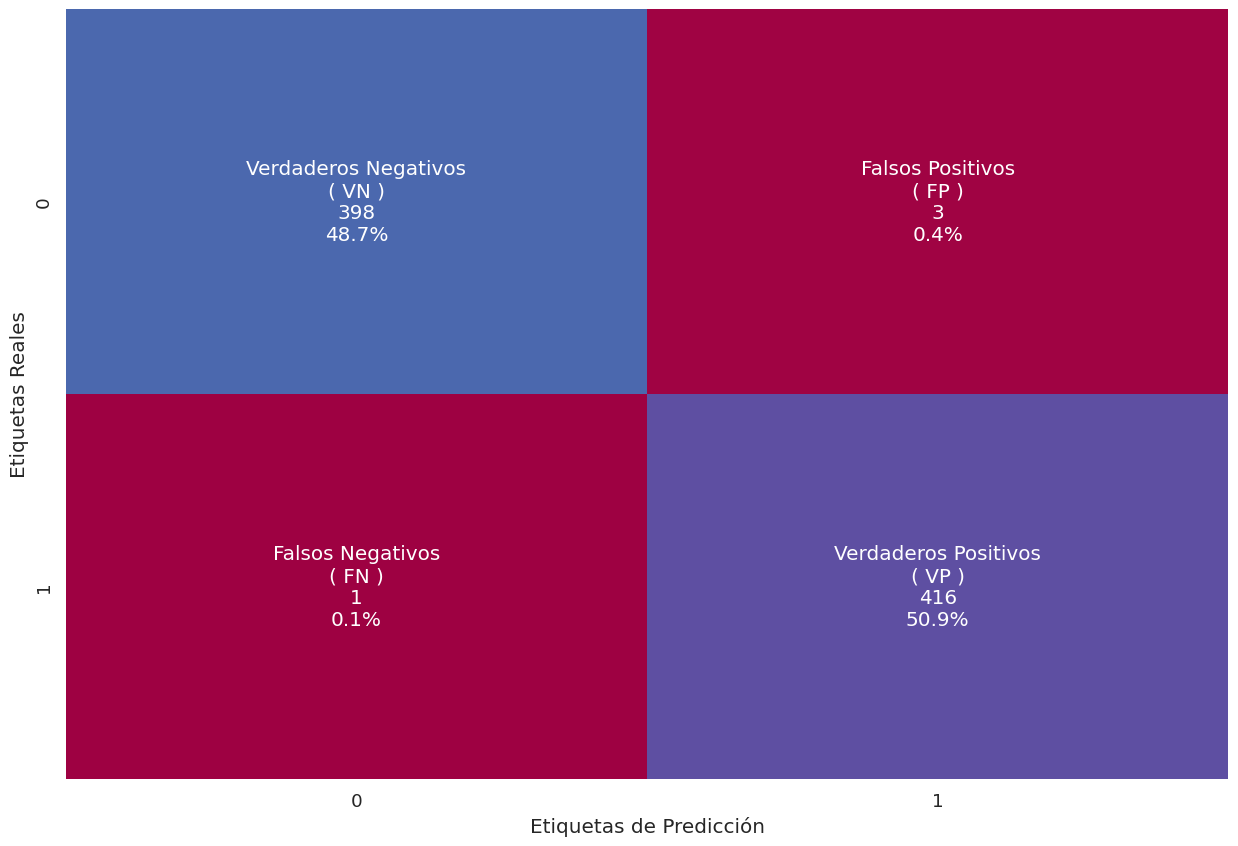

Modelo:  SVM


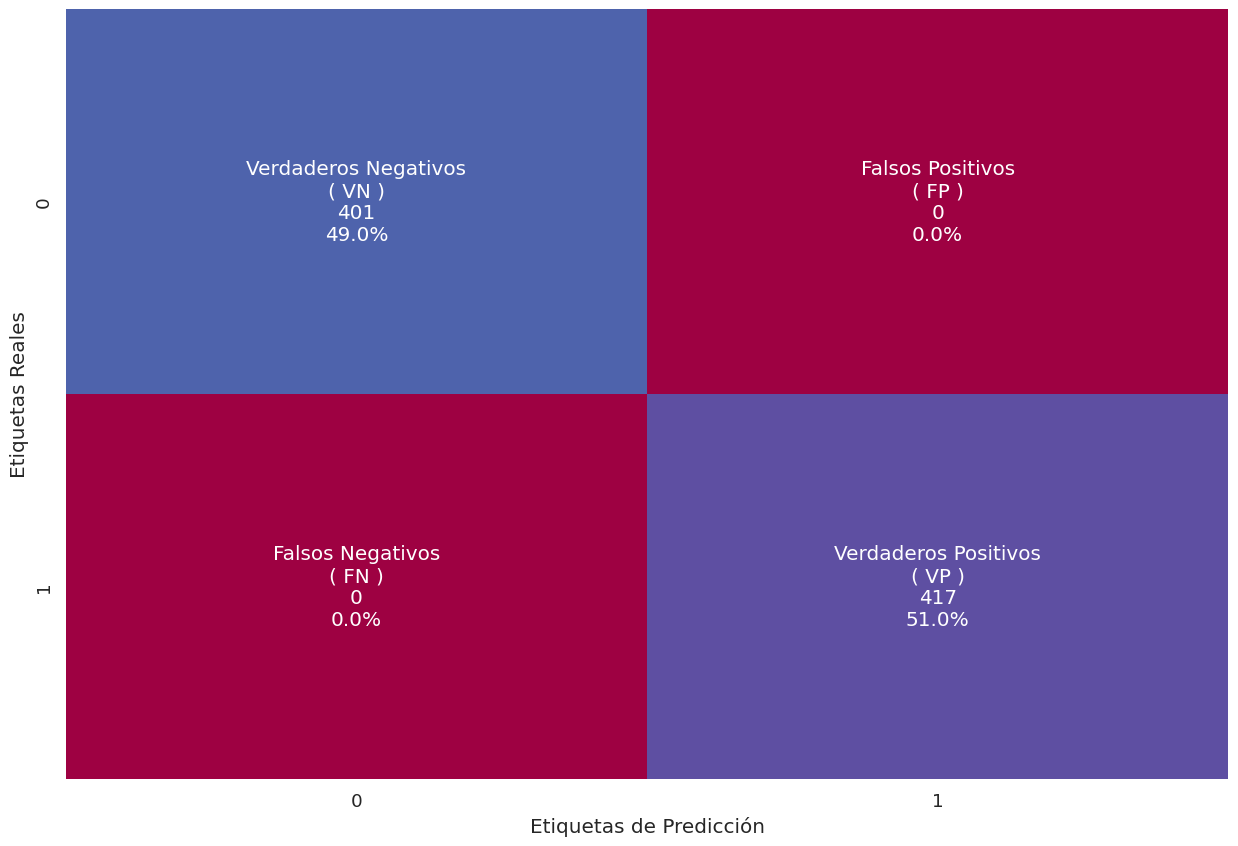

Modelo:  kNN


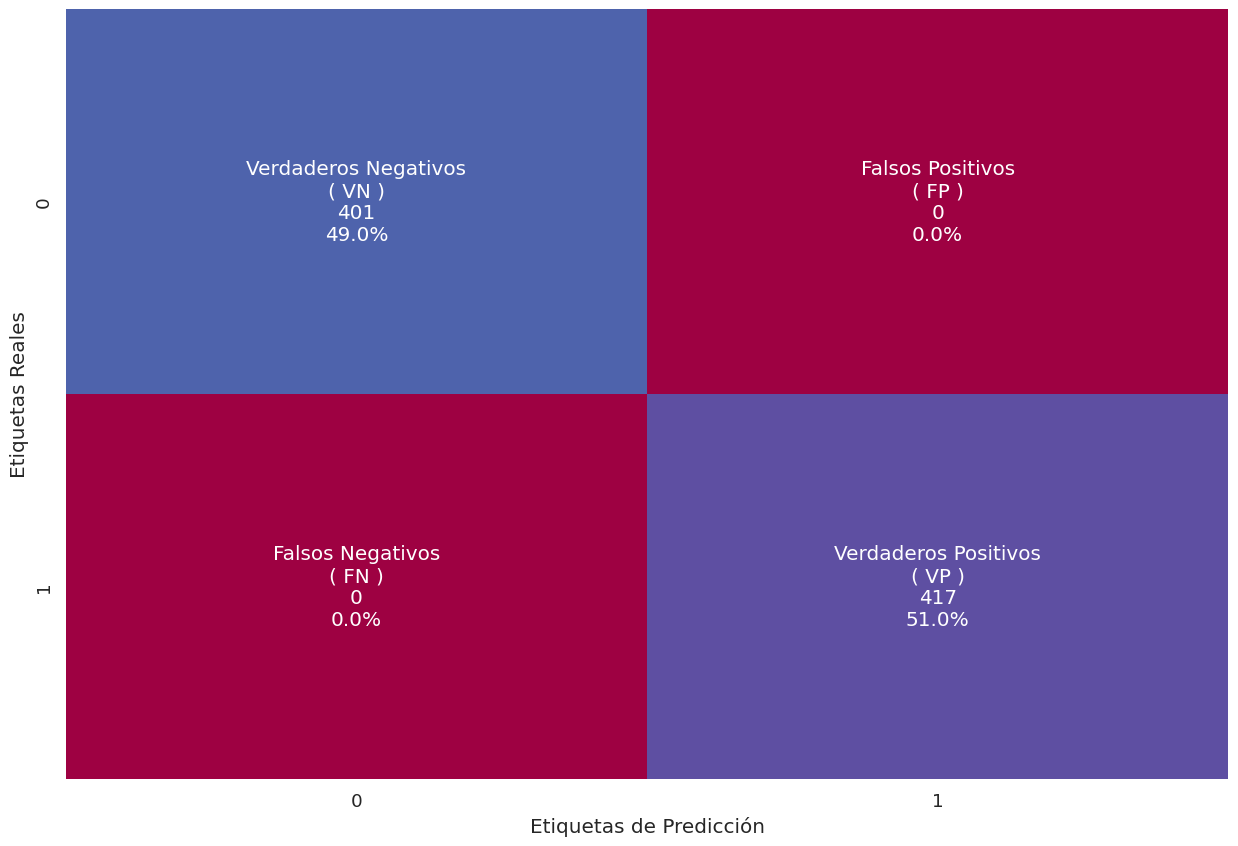

In [ ]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
accuracy_list = list()
f1score_list = list()
precision_list = list()
recall_list = list()

for i in range(len(modelos)):

  #pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  pipeline = Pipeline(steps=[('m',modelos[i])])

  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
  #scores = cross_validate(pipeline, Xtv, np.ravel(ytv), scoring=('accuracy','f1','precision','recall'), cv=cv)
  #yhat = cross_val_predict(pipeline, Xtv, ytv, cv=cv)

  # Entrenamiento del Pipeline
  pipeline.fit(Xtv,ytv)

  # Prediccion del conjunto de entrenamiento y validacion
  yhat = pipeline.predict(Xtv)

  print('Modelo: ',nombres[i])
  mi_cm(ytv, yhat)
  accuracy, f1score, precision, recall = mis_metricas(ytv,yhat)
  accuracy_list.append(accuracy)
  f1score_list.append(f1score)
  precision_list.append(precision)
  recall_list.append(recall)

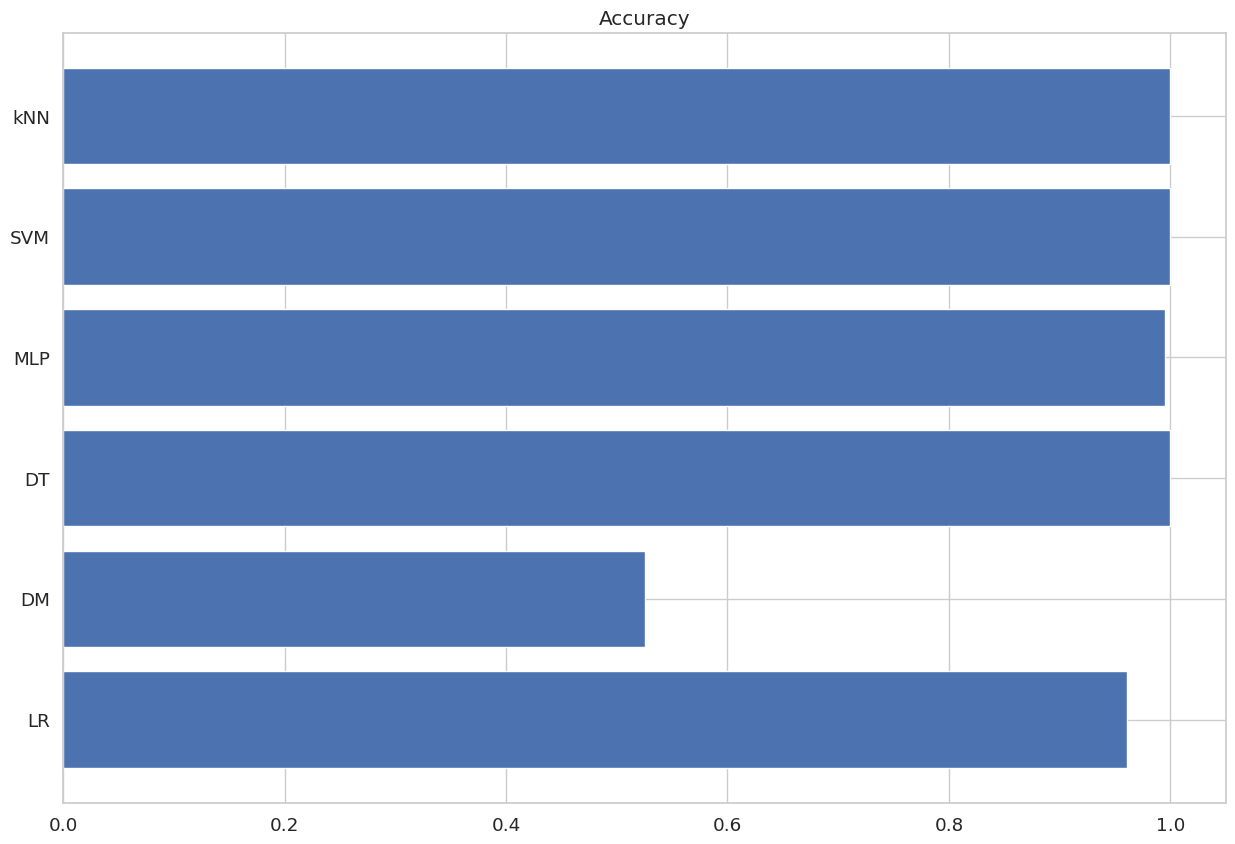

In [ ]:
plt.barh(nombres, accuracy_list)
plt.title("Accuracy")
plt.show()

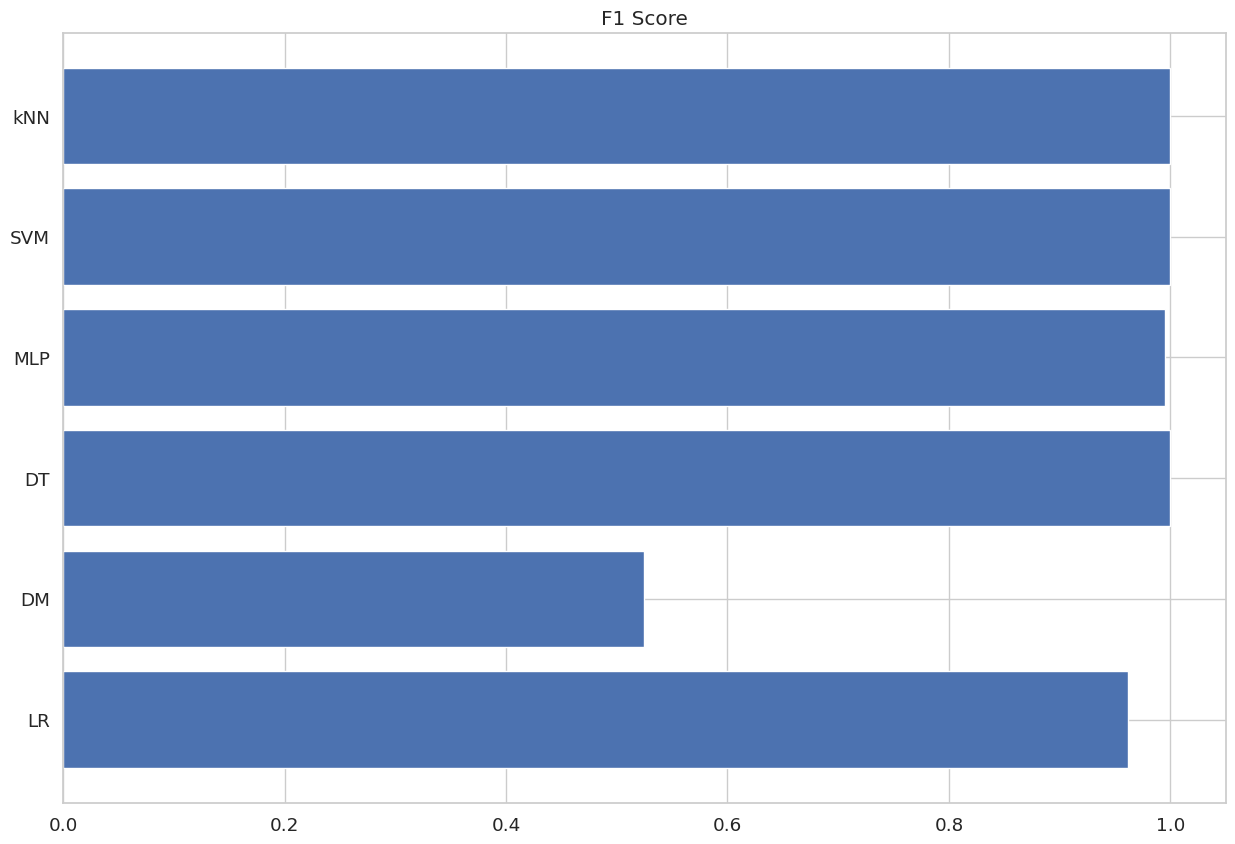

In [ ]:
plt.barh(nombres, f1score_list)
plt.title("F1 Score")
plt.show()

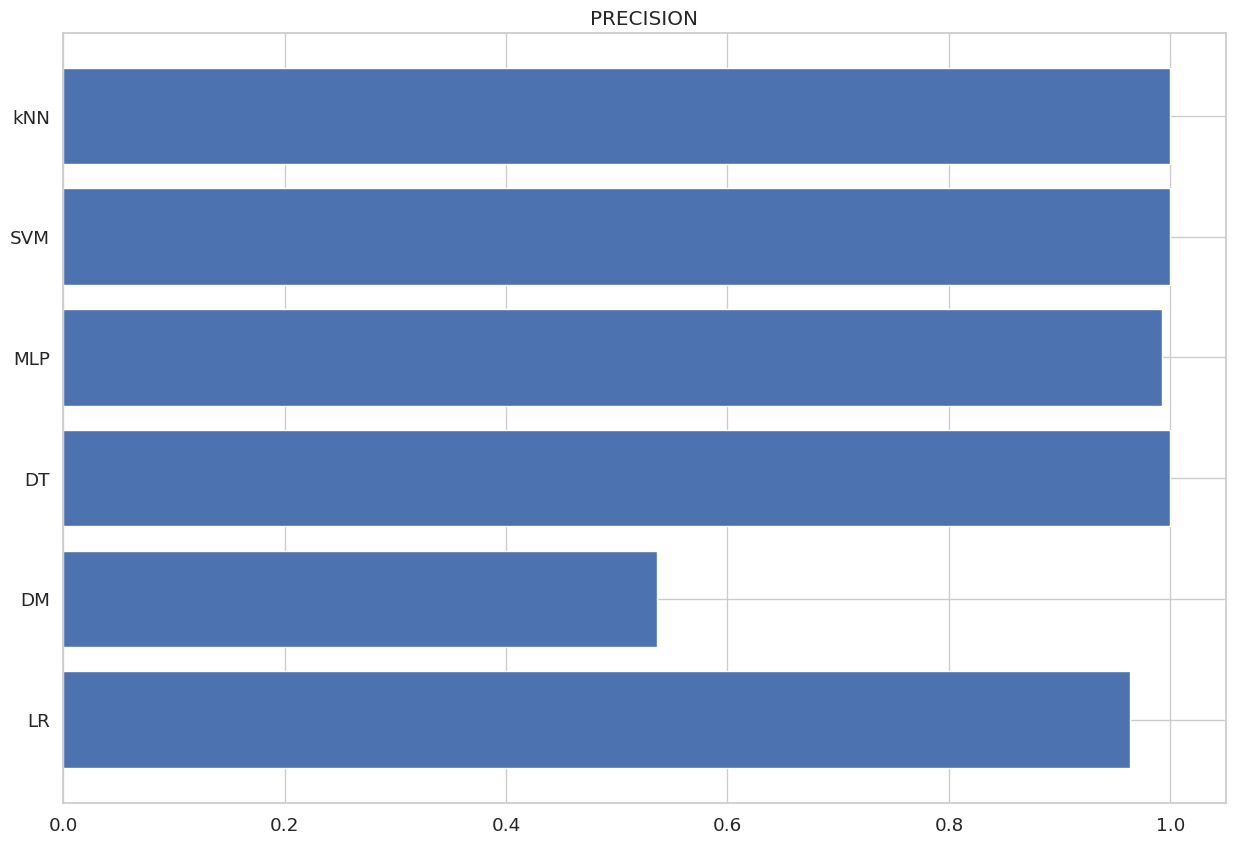

In [ ]:
plt.barh(nombres, precision_list)
plt.title("PRECISION")
plt.show()

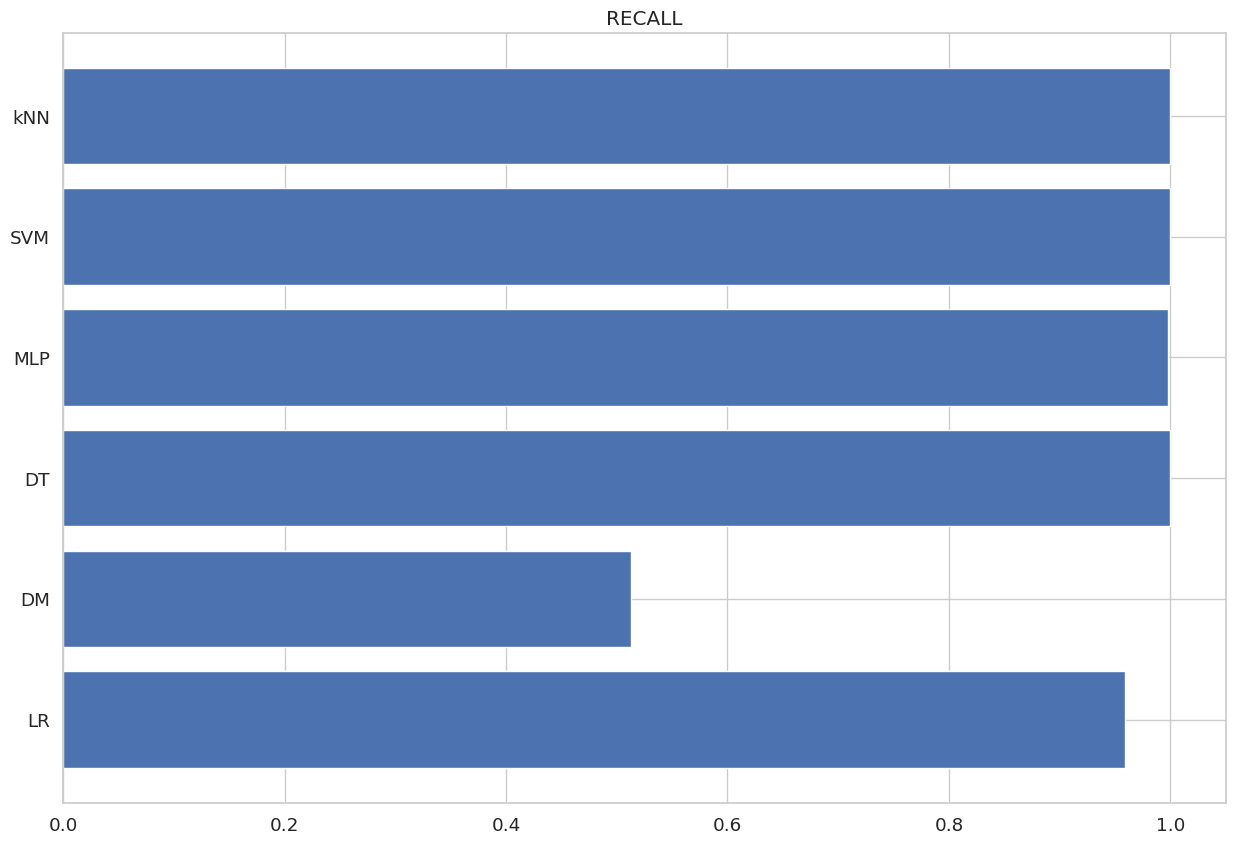

In [ ]:
plt.barh(nombres, recall_list)
plt.title("RECALL")
plt.show()

## **Evaluación**

TBD

## **Despliegue**

TBD

## **Monitoreo y Mantenimiento**

TBD

## **Bibliografía**

* Checking images for similarity with OpenCV. (s. f.). Stack Overflow. https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv
* How to compare two images in OpenCV Python? (s. f.). https://www.tutorialspoint.com/how-to-compare-two-images-in-opencv-python#:~:text=To%20compare%20two%20images%2C%20we,width%20and%20number%20of%20channels
* Kostasthanos. (s. f.). GitHub - kostasthanos/Spot-The-Differences: Spot the differences between two images using Python and OpenCV. GitHub. https://github.com/kostasthanos/Spot-The-Differences?tab=readme-ov-file
* OpenCV University. (2023, 3 abril). Image Features & Alignment with OpenCV [Vídeo]. YouTube. https://www.youtube.com/watch?v=_o6fSMCmNnQ
* Using OpenCV for Image Similarity. (2021, 26 noviembre). OpenCV. https://forum.opencv.org/t/using-opencv-for-image-similarity/6444

## **Anexos**

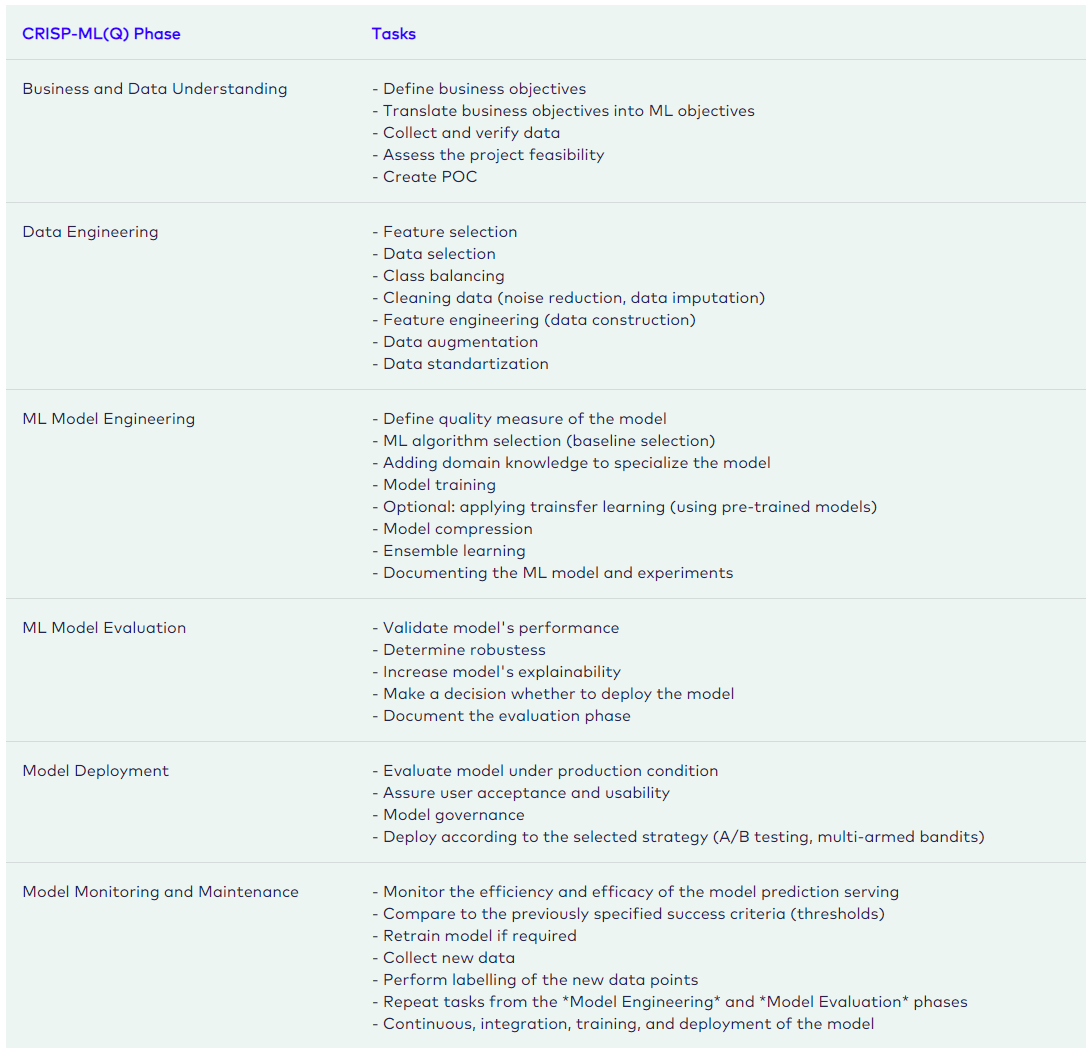

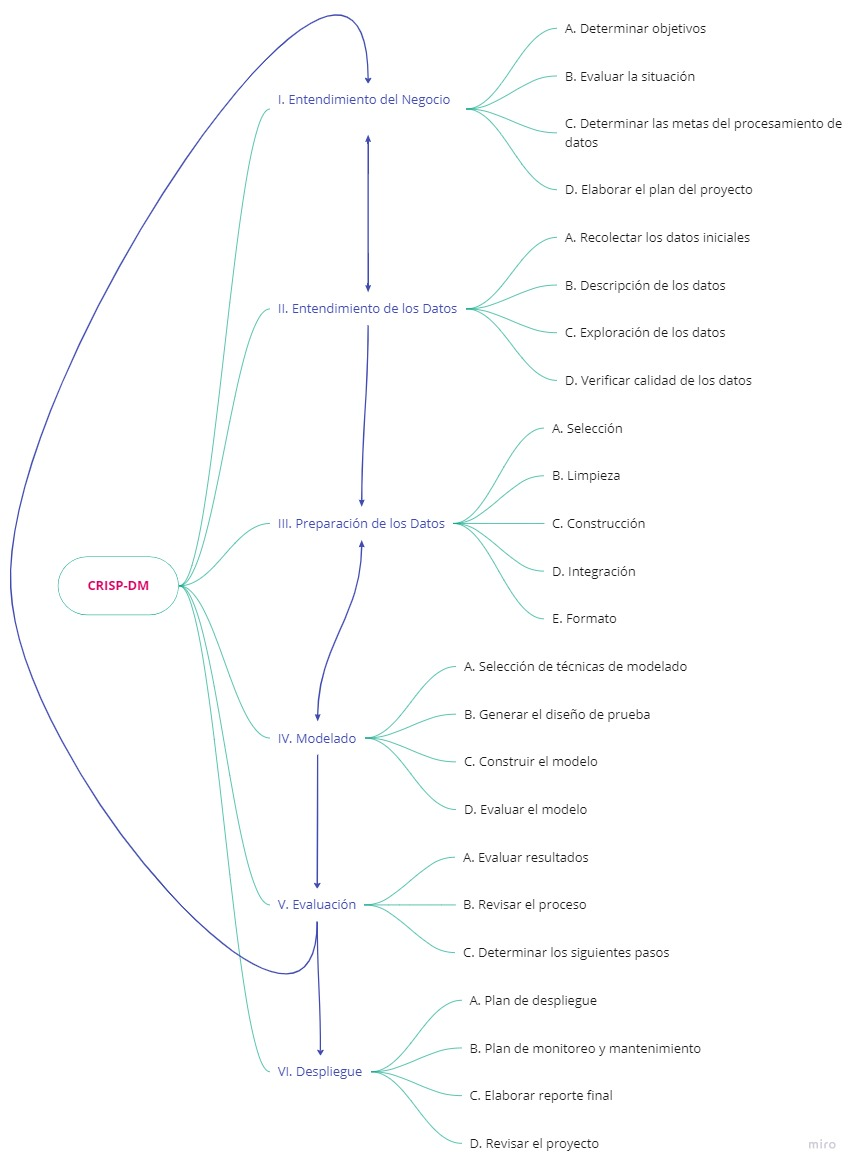

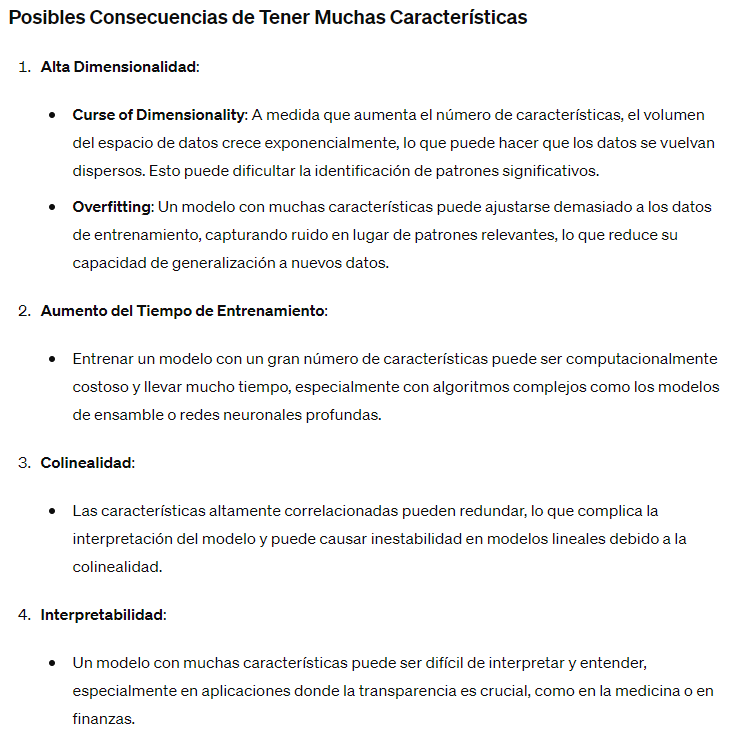

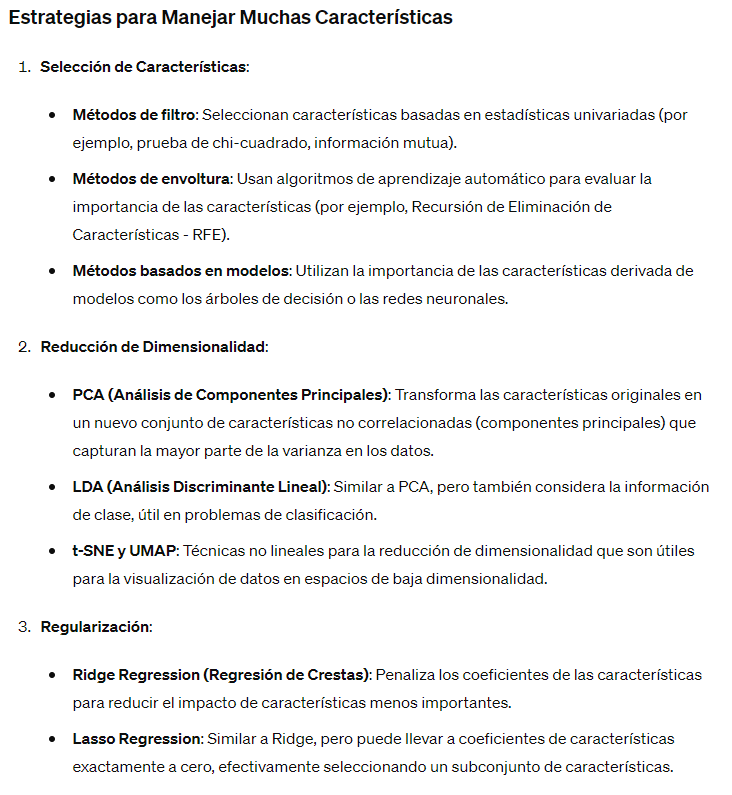

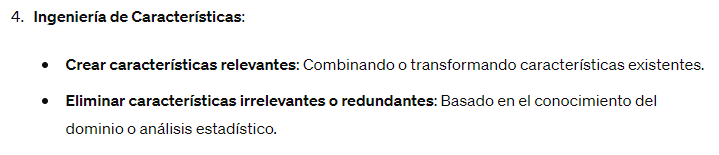

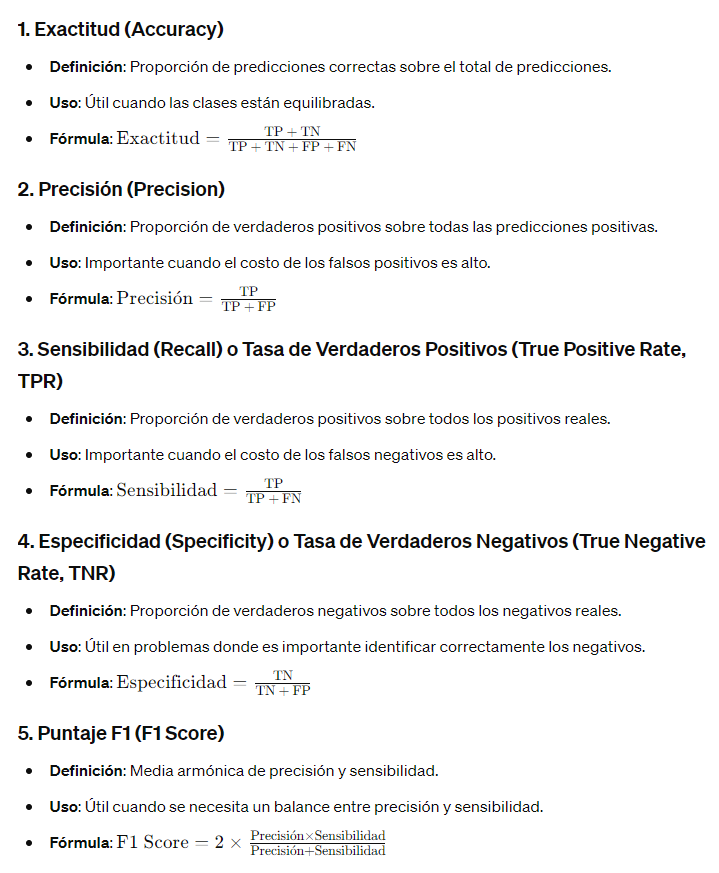

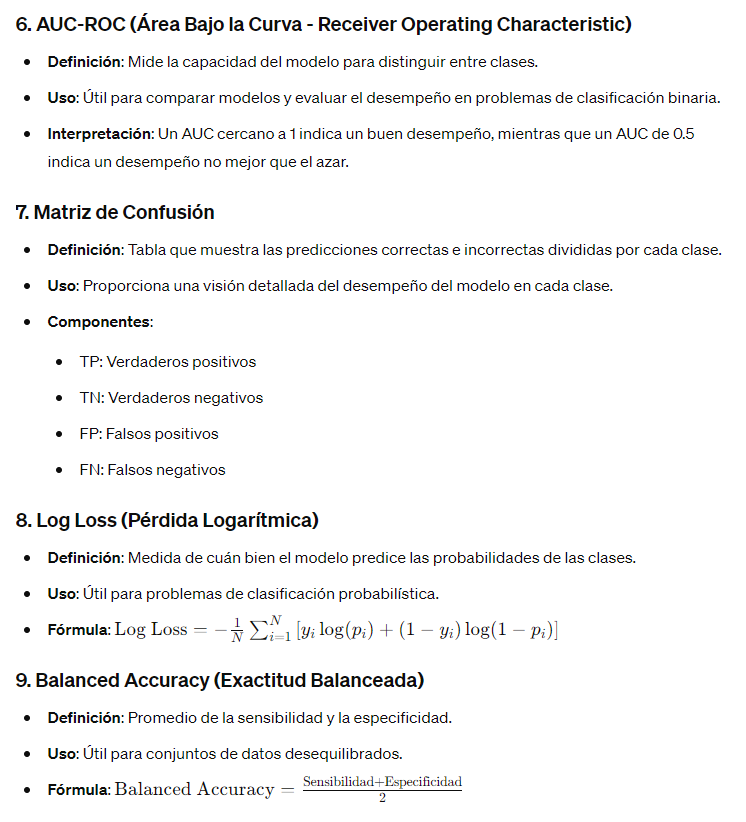

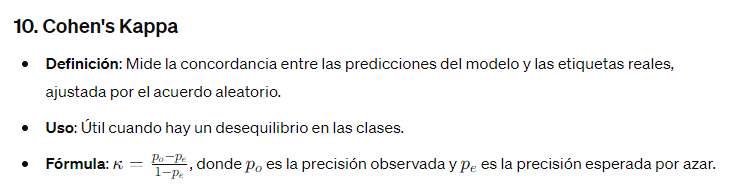